In [1]:
# First we will define our example function that we will be optimizing on.
# The prototypical function for self concordance is the log barrier function.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D projection
from itertools import combinations



def log_barrier(A, b):
    """
    A : shape (m,n) array, each row is a_i^T
    b : shape (m,)   array
    returns F(x) = sum_i -log(b_i - a_i^T x)
    """
    A = np.asarray(A)
    b = np.asarray(b).reshape(-1)
    m, n = A.shape

    def F(x):
        x = np.asarray(x).reshape(-1)
        s = b - A @ x      # shape (m,)
        if np.any(s <= 0):
            return np.inf
        return -np.sum(np.log(s))

    return F

def grad(x,F,h=1e-5):
    x = np.asarray(x).reshape(-1)
    n = x.size
    h = np.ones_like(x) * h


    # Create n copies of x (each column is x)
    X = np.tile(x.reshape(-1,1), (1, n))

    # Perturbed points: x + h e_i
    X_pert = X + np.diag(h)

    # Evaluate F on each column
    F_pert = np.array([F(X_pert[:, i]) for i in range(n)])
    F_base = F(x)

    # Finite differences: gradient approximation
    grad = (F_pert - F_base) / h

    return grad   # shape (n,)

def hess(x, F, h=1e-5):
    x = np.asarray(x, dtype=float)
    n = x.size

    H = np.zeros((n, n))

    # gradient at x
    g0 = grad(x, F, h)

    # each column j of gradient
    for j in range(n):
        x_pert = x.copy()
        x_pert[j] += h
        g_pert = grad(x_pert, F, h)
        H[:, j] = (g_pert - g0) / h

    # enforce symmetry numerically
    H = 0.5 * (H + H.T)

    return H

def newton_step(x, F, alpha = 0.5, h=1e-5):
    H = hess(x, F, h)
    g = grad(x, F, h)
    # Solve H dx = g instead of inverting
    dx = np.linalg.solve(H, g)
    x_plus = x - alpha*dx
    return x_plus

def newton_path(x0, F, steps=15, h=1e-5):
    x = np.asarray(x0, dtype=float).reshape(-1)
    path = [x.copy()]

    for k in range(steps):
        g = grad(x, F, h)
        H = hess(x, F, h)

        # Guard against singular/ill-conditioned Hessian
        try:
            dx = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            break

        x = x - dx
        path.append(x.copy())

    return np.vstack(path)  # shape: (num_iter+1, 2)





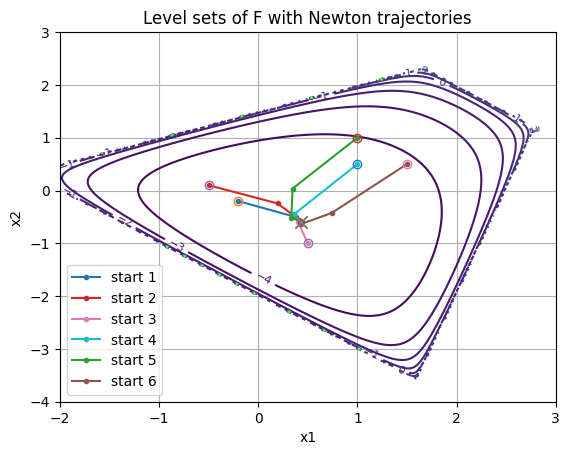

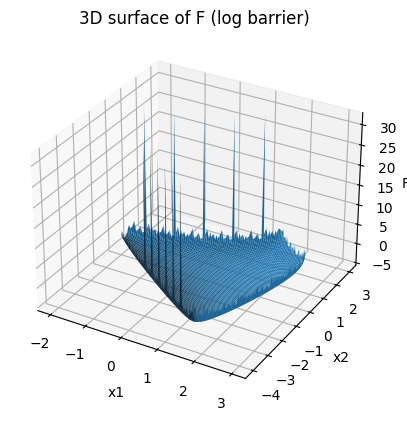

In [2]:


# ---------- example A, b (2D case) ----------
A = np.array([
    [1.0,  1.0],
    [2.0, -0.5],
    [-1.0, 2.0],
    [-1.0,-1.0]
])
b = np.array([4.0, 5.0, 3.0,2.0])

F = log_barrier(A, b)


# ---------- build grid ----------
# Choose a box that intersects the feasible region
x1_min, x1_max = -2.0, 3.0
x2_min, x2_max = -4.0, 3.0
n_pts = 200

x1 = np.linspace(x1_min, x1_max, n_pts)
x2 = np.linspace(x2_min, x2_max, n_pts)
X1, X2 = np.meshgrid(x1, x2)

Z = np.empty_like(X1)

# Evaluate F on grid (slow but clear; fine for 200x200)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        val = F([X1[i, j], X2[i, j]])
        # mask infeasible / huge values so plots don't blow up
        if not np.isfinite(val) or val > 1e3:
            Z[i, j] = np.nan
        else:
            Z[i, j] = val

# ---------- level sets (contour plot) ----------
fig1, ax1 = plt.subplots()
cs = ax1.contour(X1, X2, Z, levels=40)
ax1.clabel(cs, inline=True, fontsize=8)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Level sets of F (log barrier)')
ax1.grid(True)

# ---------- 3D surface plot ----------
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X1, X2, Z, rstride=2, cstride=2)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('F(x)')
ax2.set_title('3D surface of F (log barrier)')

# ---- Add Newton trajectories on top of level sets ----

# 6 starting points inside the feasible region
start_points = [
    np.array([-0.2, -0.2]),
    np.array([-0.5,  0.1]),
    np.array([0.5,  -1.0]),
    np.array([1.0,   0.5]),
    np.array([1.0,   1.0]),
    np.array([1.5,   0.5]),
]

num_steps = 15

paths = []
for x0 in start_points:
    path = newton_path(x0, F, steps=num_steps)
    paths.append(path)

# Plot on level sets (as before)
for idx, path in enumerate(paths):
    ax1.plot(path[:, 0], path[:, 1], '-o', markersize=3, label=f'start {idx+1}')
    ax1.plot(path[0, 0],  path[0, 1],  'o', markersize=6, fillstyle='none')  # start
    ax1.plot(path[-1, 0], path[-1, 1], 'x', markersize=8)                    # end


ax1.legend()
ax1.set_title('Level sets of F with Newton trajectories')
plt.show()

plt.show()


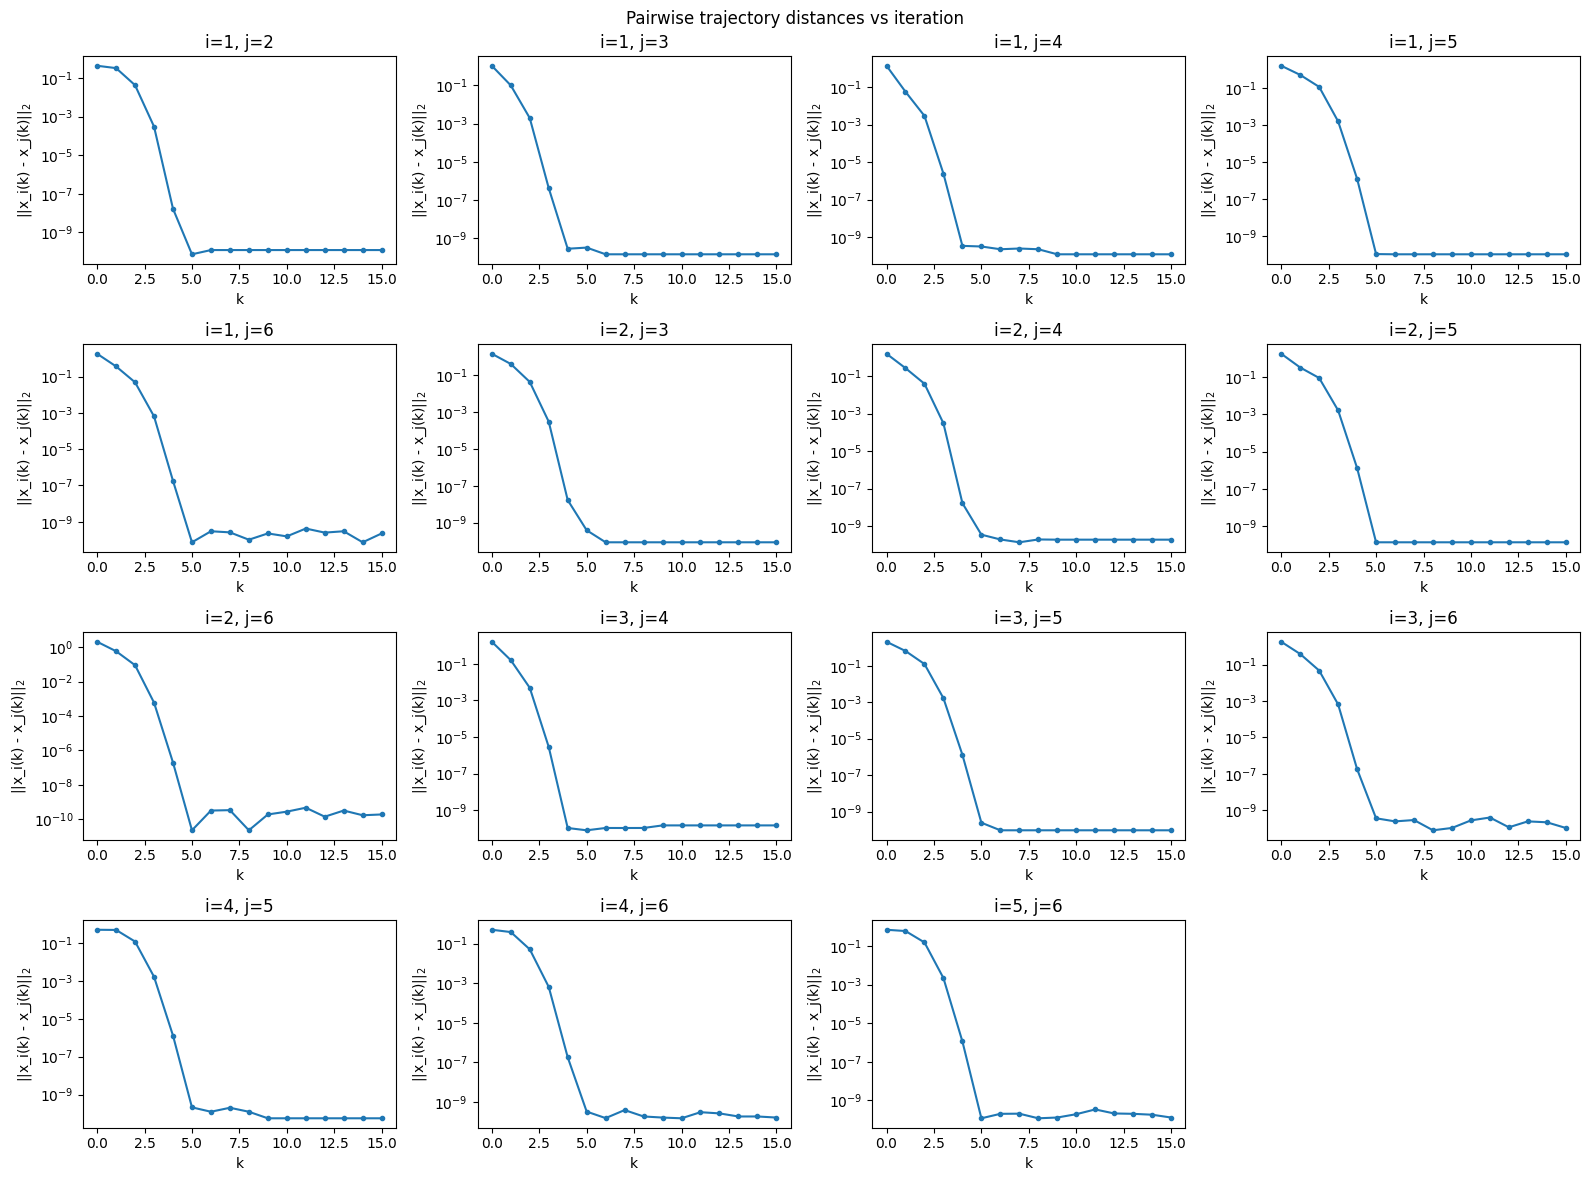

In [3]:

num_traj = len(paths)
pairs = list(combinations(range(num_traj), 2))  # all (i,j), i<j
num_pairs = len(pairs)

# Choose a subplot grid layout
rows = int(np.ceil(np.sqrt(num_pairs)))
cols = int(np.ceil(num_pairs / rows))

fig_dist, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = np.atleast_1d(axes).ravel()  # flatten in case of 1D

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    pi = paths[i]
    pj = paths[j]

    # In case trajectories have different lengths (e.g., early termination),
    # compare only up to the shortest length
    min_len = min(len(pi), len(pj))

    # Euclidean norm along the iterations
    diffs = pi[:min_len] - pj[:min_len]          # shape (min_len, 2)
    dnorm = np.linalg.norm(diffs, axis=1)       # shape (min_len,)

    k_vals = np.arange(min_len)
    ax.semilogy(k_vals, dnorm, '-o', markersize=3)
    ax.set_title(f'i={i+1}, j={j+1}')
    ax.set_xlabel('k')
    ax.set_ylabel(r'||x_i(k) - x_j(k)||$_2$')

# Hide any unused subplots if rows*cols > num_pairs
for k in range(num_pairs, len(axes)):
    fig_dist.delaxes(axes[k])

fig_dist.suptitle('Pairwise trajectory distances vs iteration')
fig_dist.tight_layout()
plt.show()

In [ ]:
# Trajectory plots for weighted Fixed Point Hessian norm

# Choose a subplot grid layout
rows = int(np.ceil(np.sqrt(num_pairs)))
cols = int(np.ceil(num_pairs / rows))

fig_dist, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = np.atleast_1d(axes).ravel()  # flatten in case of 1D

H = hess(paths[0][-1],F)
print(H)

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    pi = paths[i]
    pj = paths[j]

    # In case trajectories have different lengths (e.g., early termination),
    # compare only up to the shortest length
    min_len = min(len(pi), len(pj))

    # Euclidean norm along the iterations
    diffs = pi[:min_len] - pj[:min_len]          # shape (min_len, 2)
    dnorm = np.sqrt(np.einsum('bi,ij,bj->b', diffs, H, diffs))


    k_vals = np.arange(min_len)
    ax.semilogy(k_vals, dnorm, '-o', markersize=3)

    ax.set_title(f'i={i+1}, j={j+1}')
    ax.set_xlabel('k')
    ax.set_ylabel(r'||x_i(k) - x_j(k)||$_2$')

# Hide any unused subplots if rows*cols > num_pairs
for k in range(num_pairs, len(axes)):
    fig_dist.delaxes(axes[k])

fig_dist.suptitle('Pairwise trajectory distances vs iteration (Fixed Point Hessian Norm)')
fig_dist.tight_layout()
plt.show()

In [ ]:
# Trajectory plots for weighted Local Hessian norm

# Choose a subplot grid layout
rows = int(np.ceil(np.sqrt(num_pairs)))
cols = int(np.ceil(num_pairs / rows))

fig_dist, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = np.atleast_1d(axes).ravel()  # flatten in case of 1D



for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    pi = paths[i]
    pj = paths[j]

    # In case trajectories have different lengths (e.g., early termination),
    # compare only up to the shortest length
    min_len = min(len(pi), len(pj))

    # Local norm along the iterations
    diffs = pi[:min_len] - pj[:min_len]          # shape (min_len, 2)

    for k in range(min_len):
      H_i = hess(paths[i][k],F)
      dnorm[k] = np.sqrt(np.reshape(diffs[k],-1).T @ H_i @ np.reshape(diffs[k],-1))


    k_vals = np.arange(min_len)
    ax.semilogy(k_vals, dnorm, '-o', markersize=3)

    ax.set_title(f'i={i+1}, j={j+1}')
    ax.set_xlabel('k')
    ax.set_ylabel(r'||x_i(k) - x_j(k)||$_2$')

# Hide any unused subplots if rows*cols > num_pairs
for k in range(num_pairs, len(axes)):
    fig_dist.delaxes(axes[k])

fig_dist.suptitle('Pairwise trajectory distances vs iteration (Fixed Point Hessian Norm)')
fig_dist.tight_layout()
plt.show()